# Двумерный случай

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numba import njit

In [2]:
G = 6.67e-11
delta_t = 100

In [12]:
@njit('float64[:](float64[:],float64[:],float64[:,:])', nogil=True, fastmath=True)
def solve_deltaV(masses, r_norm, r):
    return G * delta_t * \
        np.sum(r.T * (masses / (r_norm ** 3)), axis=1)

In [13]:
class CosmicBody:
    """
    Космическое тело

    ...

    Attributes
    ----------
    mass : float
        Масса объекта
    vec_v : float
        Вектор скорости
    vec_P : float
        Радиус-вектор
    radius : float
        Радиус объекта

    Methods
    -------
    destroy()
        Уничтожает объект
    move()
        Двигает объект
    is_destroyed()
        Проверка, что объект уничтожен
    gravitate(bodys: list)
        Осуществляет взаимодействие с другими объектами
    trajectory(bodys: list)
        Вычисляет тип траектории объекта

    """

    def __init__(self, mass: float, vec_v: np.ndarray, vec_P: np.ndarray, radius=0.0):
        self.mass = mass
        self.vec_v = vec_v
        self.vec_P = vec_P
        self.delta_V = np.array([0., 0.])
        self.radius = radius

    def destroy(self):
        """Уничтожение объекта

        """
        self.mass = 0.0

    def move(self):
        """Двигает объект

        """
        if self.is_destroyed():  # проверка что объект существует
            return
        self.vec_v += self.delta_V  # изменение скорости
        self.vec_P += self.vec_v * delta_t + self.delta_V * \
            delta_t ** 2 / 2  # изменение координаты

    def is_destroyed(self):
        """Проверка что объект существует

        """
        return self.mass == 0.0

    # @jit - я делала ускорение так, но ускорить не получилось
    def gravitate(self, bodys: list):
        """
        Вычисляет действие тел на объект

        Parameters
        ----------
        bodys : list
        Список тел, с которыми нужно провзаимодействовать.

        Returns
        -------
        None
        """
        # проверка что ничего не пустое
        if self.is_destroyed():
            return
        if len(bodys) == 0:
            return
        # вычисление расстояний до других тел
        r = np.array([body.vec_P - self.vec_P for body in bodys])
        r_norm = np.sqrt(np.sum(r ** 2, axis=1))

        # проверка на столкновение
        is_destroyed = False
        for i, elem in enumerate(r_norm):
            if elem < self.radius + bodys[i].radius:
                self.destroy()
                bodys[i].destroy()
                is_destroyed = True
        if is_destroyed:
            return

        # вычисление прибавки к скорости
        masses = np.array([body.mass for body in bodys])
        self.delta_V = solve_deltaV(masses, r_norm, r)

    def trajectory(self, bodys: list):
        """
        Вычисляет траекторию тела

        Parameters
        ----------
        bodys : list
        Список тел, с которыми взаимодействует тело.

        Returns
        -------
        None
        """
        if (self.is_destroyed()):
            return "body is destroyed"
        E = ((np.linalg.norm(self.vec_v)) ** 2) / 2
        for body in bodys:
            E = E - G * body.mass / np.linalg.norm(body.vec_P - self.vec_P)
        if (E < -1e-6):
            return "ellipse"
        if (E > 1e-6):
            return "hyperbole"
        return "parabola"


class Star(CosmicBody):
    """Звезда

    Attributes
    ----------
    dim: int
        Размерность
    mass: float
        Масса звезды
    radius: float
        Радиус Звезды

    """

    def __init__(self, dim, mass, radius=0.0):
        super().__init__(mass, np.zeros(dim), np.zeros(dim), radius)

In [14]:
class World:
    """
    Класс мира

    ...

    Attributes
    ----------
    bodys : list
        Объекты в создаваемом мире
    dim: int
        Размерность
    fig:
        Картинка (только 3d)
    ax:
        Оси картинки (только 3d)
    iterations: int
        Номер иттерации для анимации
    draw_interval: int
        Промежуток иттераций для вывода анимации

    Methods
    -------
    step()
        Осуществляет один шаг в движении тел
    add_body(body)
        Добавляет тело в мир
    bodys_count()
        Вычисляет кол-во существующих тел в мире
    plot_world2d()
        Рисует траекторию объектов в двухмерном случае
    plot_world3d()
        Анимационно выводит траектории объектов в трехмерном случае
    """

    def __init__(self, bodys, dim, draw_interval=10000):
        if (dim == 3):
            # сразу создаем картинку
            self.fig = plt.figure(figsize=(12, 12))
            self.fig.show()
            self.fig.canvas.draw()
            self.ax = self.fig.add_subplot(projection='3d')
            self.iterations = 0
            self.draw_interval = draw_interval
        self.bodys = []
        self.active_trajectories = []
        self.destroyed_trajectories = []
        self.dim = dim
        for body in bodys:
            self.add_body(body)

    def step(self):
        """
        Осуществляет один шаг в движении тел.

        Сначала для каждого тела вычисляется взаимодействия, а потом они двигаются.

        Parameters
        ----------
        None

        Returns
        -------
        None
        """
        # осуществляем взаимодействие
        for i in range(len(self.bodys)):
            self.bodys[i].gravitate(self.bodys[:i] + self.bodys[i+1:])

        destroyed = {}  # уничтоженные тела
        destroyed_trajectories = {}  # уничтоженные траектории
        # передвижение тел
        for i, b in enumerate(self.bodys):
            b.move()
            if b.is_destroyed():  # проверка что тело уничтожено
                # добавляется в соответствующие списки
                destroyed[i] = b
                destroyed_trajectories[i] = self.active_trajectories[i]
                self.destroyed_trajectories.append(self.active_trajectories[i])
            else:
                self.active_trajectories[i].append(b.vec_P.copy())
        for i, b in destroyed.items():  # удаление несуществующих тел
            self.bodys.remove(b)
            self.active_trajectories.remove(destroyed_trajectories[i])

    def add_body(self, body):
        """Добавление тела в мир

        """
        self.bodys.append(body)
        self.active_trajectories.append([body.vec_P.copy()])

    def bodys_count(self):
        """Кол-во тел в системе

        """
        return len(self.bodys)

    def plot_world2d(self):
        """Вывод всех траекторий в виде графика

        Note
        -----
        только 2d
        """
        assert self.dim == 2
        for trajectory in self.active_trajectories + self.destroyed_trajectories:
            x_values = [item[0] for item in trajectory]
            y_values = [item[1] for item in trajectory]
            plt.scatter(x_values, y_values)

    def plot_world3d(self):
        """Вывод всех траекторий в виде графика

        Note
        -----
        только 3d
        """
        assert self.dim == 3
        self.iterations += 1
        # будем рисовать не каждую итерацию, а каждые 10000, чтобы было быстрее
        if self.iterations == self.draw_interval:
            self.ax.clear()
            self.iterations = 0
            for trajectory in self.active_trajectories + self.destroyed_trajectories:
                x_values = [item[0] for item in trajectory]
                y_values = [item[1] for item in trajectory]
                z_values = [item[2] for item in trajectory]
                self.ax.scatter(x_values, y_values, z_values)
            self.fig.canvas.draw()

In [15]:
def test_two_fishes2d():
    """Тест на столкновение

    """
    times = np.arange(0, 100 * 24 * 36)
    varvara = Star(2, 1.9e30)
    fish1 = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), -29800. / np.sqrt(
        2)]), np.array([146e9 / np.sqrt(2), 146e9 / np.sqrt(2)]), 7e6)
    fish2 = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), 29800. / np.sqrt(
        2)]), np.array([146e9 / np.sqrt(2), -(146e9 / np.sqrt(2))]), 7e6)
    world = World([varvara, fish1, fish2], 2)

    for time in times:
        world.step()
    world.plot_world2d()
    plt.show()

    assert world.bodys_count() == 1

In [16]:
def test_one_fish2d():
    """Тест планета Земля

    """
    times = np.arange(0, 365.25 * 24 * 36)
    varvara = Star(2, 1.9e30)
    fish = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), -29800. / np.sqrt(
        2)]), np.array([146e9 / np.sqrt(2), 146e9 / np.sqrt(2)]), 7e6)
    world = World([varvara, fish], 2)

    for time in times:
        world.step()
    world.plot_world2d()
    plt.show()

    assert world.bodys_count() == 2

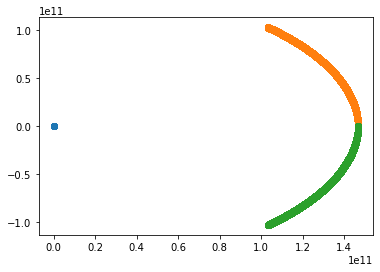

3.8623993396759033


In [20]:
import time

start_time = time.time()
test_two_fishes2d()
end_time = time.time()
print(end_time - start_time)

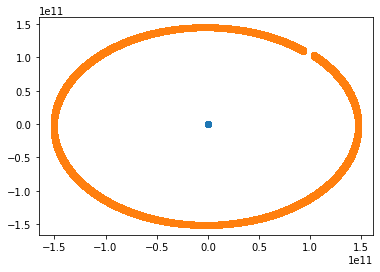

In [18]:
test_one_fish2d()

In [ ]:
def test_trajectory():
    """Тест на определение траекторий

    """
    times = np.arange(0, 50 * 24 * 36)
    varvara = Star(2, 1.9e30)
    fish = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), -29800. / np.sqrt(
        2)]), np.array([146e9 / np.sqrt(2), 146e9 / np.sqrt(2)]), 7e6)
    assert fish.trajectory([varvara]) == "ellipse"
    fish1 = CosmicBody(3.33e23, np.array(
        [-29800., -29800.]), np.array([146e9, 146e9]), 7e6)
    assert fish1.trajectory([varvara]) == "hyperbole"
    fish2 = CosmicBody(3.33e23, np.array(
        [np.sqrt(1736027397.260274), 0]), np.array([146e9, 0]), 7e6)
    assert fish2.trajectory([varvara]) == "parabola"

In [ ]:
test_trajectory()

## Похожие тесты

In [ ]:
def test_two_fishes3D():
    times = np.arange(0, 100 * 24 * 36)
    varvara = Star(3, 1.9e30)
    fish1 = CosmicBody(3.33e23, np.array([29800. / np.sqrt(3), -29800. / np.sqrt(3), 29800. / np.sqrt(
        3)]), np.array([146e9 / np.sqrt(3), 146e9 / np.sqrt(3), 146e9 / np.sqrt(3)]), 7e6)
    fish2 = CosmicBody(3.33e23, np.array([29800. / np.sqrt(3), 29800. / np.sqrt(3), 29800. / np.sqrt(
        3)]), np.array([146e9 / np.sqrt(3), -(146e9 / np.sqrt(3)), 146e9 / np.sqrt(3)]), 7e6)
    world = World([varvara, fish1, fish2], 3)

    for time in times:
        world.step()
        world.plot_world3d()

    assert world.bodys_count() == 1

In [ ]:
def test_one_fish3D():
    times = np.arange(0, 100 * 24 * 36)
    varvara = Star(3, 1.9e30)
    fish = CosmicBody(3.33e23, np.array([29800. / np.sqrt(3), -29800. / np.sqrt(2), -29800. / np.sqrt(
        6)]), np.array([146e9 / np.sqrt(3), 146e9 / np.sqrt(3), 146e9 / np.sqrt(3)]), 7e6)
    world = World([varvara, fish], 3)

    for time in times:
        world.step()
        world.plot_world3d()

    assert world.bodys_count() == 2

In [ ]:
%matplotlib notebook

test_two_fishes3D()

In [ ]:
%matplotlib notebook

test_one_fish3D()

In [ ]:
import unittest


class TestTrajectories(unittest.TestCase):

    def test_two_fishes2d(self):
        """Тест на столкновение

        """
        times = np.arange(0, 100 * 24 * 36)
        varvara = Star(2, 1.9e30)
        fish1 = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), -29800. / np.sqrt(
            2)]), np.array([146e9 / np.sqrt(2), 146e9 / np.sqrt(2)]), 7e6)
        fish2 = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), 29800. / np.sqrt(
            2)]), np.array([146e9 / np.sqrt(2), -(146e9 / np.sqrt(2))]), 7e6)
        world = World([varvara, fish1, fish2], 2)

        for time in times:
            world.step()

        self.assertTrue(world.bodys_count() == 1)

    def test_trajectory(self):
        """Тест на определение траекторий

        """
        times = np.arange(0, 50 * 24 * 36)
        varvara = Star(2, 1.9e30)
        fish = CosmicBody(3.33e23, np.array([29800. / np.sqrt(2), -29800. / np.sqrt(
            2)]), np.array([146e9 / np.sqrt(2), 146e9 / np.sqrt(2)]), 7e6)
        self.assertTrue(fish.trajectory([varvara]) == "ellipse")
        fish1 = CosmicBody(3.33e23, np.array(
            [-29800., -29800.]), np.array([146e9, 146e9]), 7e6)
        self.assertTrue(fish1.trajectory([varvara]) == "hyperbole")
        fish2 = CosmicBody(3.33e23, np.array(
            [np.sqrt(1736027397.260274), 0]), np.array([146e9, 0]), 7e6)
        self.assertTrue(fish2.trajectory([varvara]) == "parabola")

In [ ]:
unittest.main(argv=['first-arg-is-ignored'], exit=False)